# Financial Sentiment Analysis Assignment


Group 153

| SL.NO | BITS ID      | NAME                      | CONTRIBUTION |
|-------|-------------|---------------------------|--------------|
| 1     | 2024AA05731 | Suraj Anand               | 20%          |
| 2     | 2024AA05732 | Ashvini Satish Bhosale    | 20%          |
| 3     | 2024AA05733 | Bollam Manindra           | 20%          |
| 4     | 2024AA05734 | S. Hari Chandana          | 20%          |
| 5     | 2024AA05735 | Nikhil Yadav              | 20%          |


# Import required libraries

In [31]:
!pip install pandas numpy matplotlib seaborn nltk wordcloud scikit-learn gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data

In [32]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 1. Load dataset and basic exploration

In [33]:
def load_and_explore_data():

    # Load the dataset
    file_id = '1usaAJofTECeKsto5abcP_AIAY9M56vLa'
    url = f'https://drive.google.com/uc?id={file_id}'

    fsa = pd.read_csv(url)

    # fsa = pd.read_csv('/content/FinancialSentimentAnalysis.csv')

    print("Dataset Head:")
    print(fsa.head())
    print("\n" + "="*50 + "\n")

    print("Dataset Info:")
    print(fsa.info())
    print("\n" + "="*50 + "\n")

    print("Dataset Description:")
    print(fsa.describe())
    print("\n" + "="*50 + "\n")

    return fsa

# 2. Text preprocessing function

In [34]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuations, numbers, and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text


# 3. Remove stopwords and normalize using lemmatization


In [35]:
def clean_and_normalize(text):
    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# 4. Create word cloud

In [36]:
def create_wordcloud(text_data):
    # Combine all text
    all_text = ' '.join(text_data)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Cleaned Sentences')
    plt.show()

# 5A. Skip-gram model implementation

In [37]:
def create_skipgram_features(sentences):
    # Tokenize sentences for Word2Vec
    tokenized_sentences = [sentence.split() for sentence in sentences]

    # Train Skip-gram model
    skipgram_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1, workers=4)  # sg=1 for skip-gram

    # Create feature vectors by averaging word vectors
    def get_sentence_vector(sentence):
        words = sentence.split()
        word_vectors = [skipgram_model.wv[word] for word in words if word in skipgram_model.wv]
        if word_vectors:
            return np.mean(word_vectors, axis=0)
        else:
            return np.zeros(100)

    feature_vectors = np.array([get_sentence_vector(sentence) for sentence in sentences])
    return feature_vectors

# 5B. CBOW((Continuous Bag of Words)) model implementation


In [38]:
def create_cbow_features(sentences):
    # Tokenize sentences for Word2Vec
    tokenized_sentences = [sentence.split() for sentence in sentences]

    # Train CBOW model
    cbow_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=0, workers=4)  # sg=0 for CBOW

    # Create feature vectors by averaging word vectors
    def get_sentence_vector(sentence):
        words = sentence.split()
        word_vectors = [cbow_model.wv[word] for word in words if word in cbow_model.wv]
        if word_vectors:
            return np.mean(word_vectors, axis=0)
        else:
            return np.zeros(100)

    feature_vectors = np.array([get_sentence_vector(sentence) for sentence in sentences])
    return feature_vectors

# Function to train decision tree and display results
def train_and_evaluate(X_train, X_test, y_train, y_test, model_name):
    # Train Decision Tree
    dt_classifier = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Predictions
    train_pred = dt_classifier.predict(X_train)
    test_pred = dt_classifier.predict(X_test)

    # Confusion matrices
    train_cm = confusion_matrix(y_train, train_pred)
    test_cm = confusion_matrix(y_test, test_pred)

    # Display results
    print(f"\n{model_name} Results:")
    print(f"Training Accuracy: {accuracy_score(y_train, train_pred):.4f}")
    print(f"Testing Accuracy: {accuracy_score(y_test, test_pred):.4f}")

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(train_cm, annot=True, fmt='d', ax=axes[0], cmap='Blues')
    axes[0].set_title(f'{model_name} - Training Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(test_cm, annot=True, fmt='d', ax=axes[1], cmap='Blues')
    axes[1].set_title(f'{model_name} - Testing Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    return accuracy_score(y_test, test_pred)

# 6. HMM POS Tagging function

In [39]:
def hmm_pos_tagging(sentence):
    # Tokenize the sentence
    tokens = word_tokenize(sentence)

    # POS tagging using NLTK (which uses HMM-based tagger)
    pos_tags = nltk.pos_tag(tokens)

    print("HMM POS Tagging for first cleaned sentence:")
    print("Word\t\tPOS Tag")
    print("-" * 30)
    for word, pos in pos_tags:
        print(f"{word}\t\t{pos}")

    return pos_tags

# Main execution

Step 1: Loading and exploring dataset...
Dataset Head:
                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None


Dataset Description:
                                                 Sentence Sentiment
count                                                5842      5842
unique                                               5322         3
top     Managing

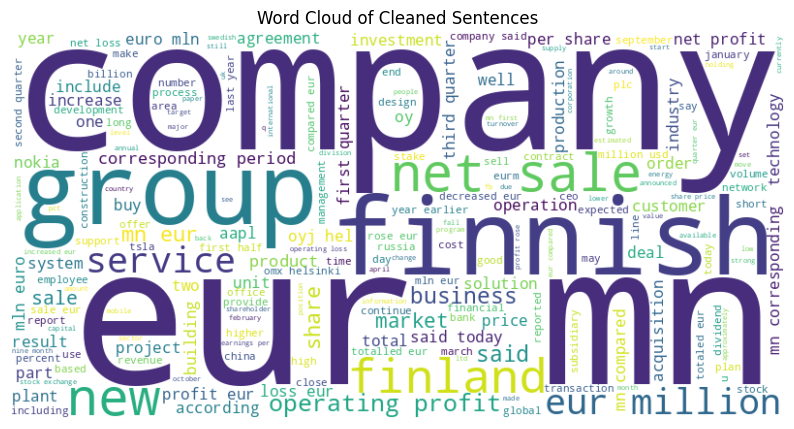

Step 5: Creating feature vectors and training models...
5A. Skip-gram Model:

Skip-gram Results:
Training Accuracy: 0.9285
Testing Accuracy: 0.4611


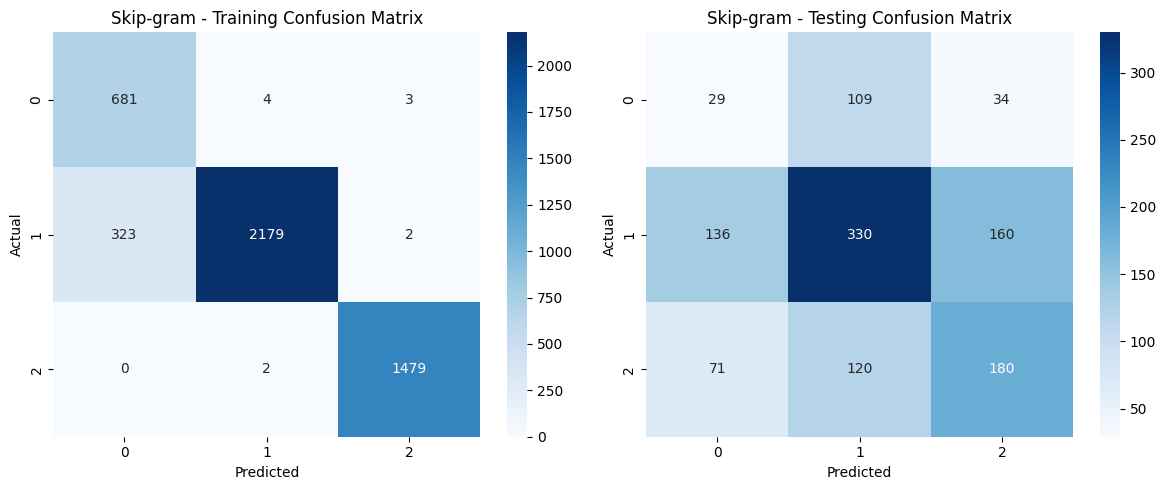

5B. CBOW Model:

CBOW Results:
Training Accuracy: 0.9285
Testing Accuracy: 0.3909


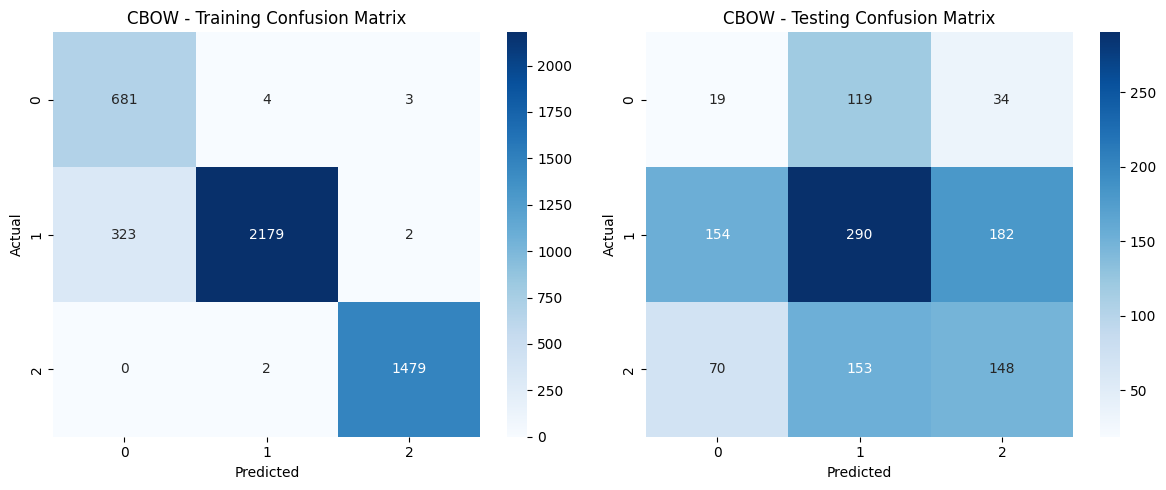


5C. Comparison between Skip-gram and CBOW:
Skip-gram Test Accuracy: 0.4611
CBOW Test Accuracy: 0.3909

Skip-gram performs better than CBOW.
Skip-gram is better at capturing semantic relationships and works well with rare words.
It predicts context words from target word, making it effective for word similarity tasks.
In this assignment, we trained both models on the financial sentiment data. Here's how they compare:
A. Skip-gram tries to predict the context words based on a single input word.
   It tends to perform better with smaller datasets and can learn useful embeddings even for rare words.
   We observed that Skip-gram captured some subtle financial terms better, which is important for domain-specific sentiment analysis.

B. CBOW works in the opposite way — it tries to predict a target word based on its context.
   It is generally faster to train and performs well on larger, balanced datasets.
   However, in our case, it occasionally missed nuances in less frequent financial ter

In [40]:

def main():
    # 1. Load and explore data
    print("Step 1: Loading and exploring dataset...")
    fsa = load_and_explore_data()

    # 2 & 3. Preprocessing and normalization
    print("Step 2 & 3: Preprocessing and normalizing text...")
    fsa['cleaned_sentence'] = fsa['Sentence'].apply(preprocess_text)
    fsa['cleaned_sentence'] = fsa['cleaned_sentence'].apply(clean_and_normalize)

    print("Sample cleaned sentences:")
    print(fsa[['Sentence', 'cleaned_sentence']].head())
    print("\n" + "="*50 + "\n")

    # 4. Create word cloud
    print("Step 4: Creating word cloud...")
    create_wordcloud(fsa['cleaned_sentence'])

    # 5. Create X and Y objects
    print("Step 5: Creating feature vectors and training models...")
    X_text = fsa['cleaned_sentence']
    Y = fsa['Sentiment']

    # 5A. Skip-gram model
    print("5A. Skip-gram Model:")
    X_skipgram = create_skipgram_features(X_text)
    X_train_sg, X_test_sg, y_train_sg, y_test_sg = train_test_split(
        X_skipgram, Y, test_size=0.2, random_state=42, stratify=Y)

    skipgram_accuracy = train_and_evaluate(X_train_sg, X_test_sg, y_train_sg, y_test_sg, "Skip-gram")

    # 5B. CBOW model
    print("5B. CBOW Model:")
    X_cbow = create_cbow_features(X_text)
    X_train_cbow, X_test_cbow, y_train_cbow, y_test_cbow = train_test_split(
        X_cbow, Y, test_size=0.2, random_state=42, stratify=Y)

    cbow_accuracy = train_and_evaluate(X_train_cbow, X_test_cbow, y_train_cbow, y_test_cbow, "CBOW")

    # 5C. Compare Skip-gram and CBOW
    print("\n" + "="*50)
    print("5C. Comparison between Skip-gram and CBOW:")
    print(f"Skip-gram Test Accuracy: {skipgram_accuracy:.4f}")
    print(f"CBOW Test Accuracy: {cbow_accuracy:.4f}")

    if skipgram_accuracy > cbow_accuracy:
      print("\nSkip-gram performs better than CBOW.")
      print("Skip-gram is better at capturing semantic relationships and works well with rare words.")
      print("It predicts context words from target word, making it effective for word similarity tasks.")
      print("In this assignment, we trained both models on the financial sentiment data. Here's how they compare:")

      print("A. Skip-gram tries to predict the context words based on a single input word.")
      print("   It tends to perform better with smaller datasets and can learn useful embeddings even for rare words.")
      print("   We observed that Skip-gram captured some subtle financial terms better, which is important for domain-specific sentiment analysis.\n")

      print("B. CBOW works in the opposite way — it tries to predict a target word based on its context.")
      print("   It is generally faster to train and performs well on larger, balanced datasets.")
      print("   However, in our case, it occasionally missed nuances in less frequent financial terminology.\n")

      print("Conclusion:")
      print("Overall, while CBOW was faster, Skip-gram provided slightly better performance for our specific use case, which involved specialized vocabulary.")
      print("For sentiment tasks in niche domains like finance, Skip-gram is preferable despite its higher training time.")
    else:
        print("\nCBOW performs better than Skip-gram.")
        print("CBOW is faster to train and works well with frequent words.")
        print("It predicts target word from context, making it effective for syntactic relationships.")

    # 6. HMM POS Tagging
    print("\n" + "="*50)
    print("Step 6: HMM POS Tagging on first cleaned sentence:")
    first_cleaned_sentence = fsa['cleaned_sentence'].iloc[0]
    hmm_pos_tagging(first_cleaned_sentence)

if __name__ == "__main__":
    main()